## Imports

In [1]:

from sklearn.metrics import  confusion_matrix
import spacy
import nltk
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, SelectPercentile
from sklearn.svm import SVR
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
random_seed = 42
from xgboost import XGBClassifier
tqdm.pandas()

/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## data

### read

In [2]:
df_features = pd.read_csv('../data/processed/processed_dataset.csv')
df_features

,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,...,child_lemma,child_pos,child_tag,child_shape,child_is_alpha,child_is_stop,child_morph,child_ner,child_ner_start_end,parent_ner_start_end
0,sci,1,ter,person,:ARG0,nsubj,tem,ter,VERB,VERB,...,Meyer,PROPN,PROPN,Xxxxx,True,False,Gender=Masc|Number=Sing,PER,"[0, 1]",NaN
1,sci,4,fazer,isso,:ARG1,nao_tem_dep,feito,fazer,VERB,VERB,...,isso,PRON,PRON,Xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
2,sci,4,fazer,universidade,:ARG3,obl,feito,fazer,VERB,VERB,...,universidade,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN
3,sci,12,acontecer,isso,:ARG1,nsubj,acontece,acontecer,VERB,VERB,...,isso,PRON,PRON,xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
4,sci,16,entender,otimista,:ARG0,nsubj,entendem,entender,VERB,VERB,...,otimista,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Plur,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,PropBankBr_v1.1_Dep,propbank_3347,ser,Abram_Szajman,ARG1,nao_tem_dep,é,ser,AUX,AUX,...,Abram_Szajman,PROPN,PROPN,Xxxxx_Xxxxx,False,False,Gender=Masc|Number=Sing,LOC,"[0, 1]",NaN
13242,PropBankBr_v1.1_Dep,propbank_3347,ser,presidente,ARG2,ROOT,é,ser,AUX,AUX,...,presidente,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Sing,NaN,NaN,NaN
13243,PropBankBr_v1.1_Dep,propbank_3348,surpreender,que,ARG0,nsubj,surpreendeu,surpreender,VERB,VERB,...,que,PRON,PRON,xxx,True,True,Gender=Masc|Number=Sing|PronType=Rel,NaN,NaN,NaN
13244,PropBankBr_v1.1_Dep,propbank_3348,surpreender,galera,ARG1,obj,surpreendeu,surpreender,VERB,VERB,...,galera,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN


In [3]:
# dropa colunas inuteis
df_features = df_features.drop(['parent_shape',
       'parent_is_alpha', 'parent_is_stop', 'parent_morph', 'child_shape',
       'child_is_alpha', 'child_is_stop', 'child_morph', 
       'child_ner_start_end', 'parent_ner_start_end'],axis = 1)

df_features.columns

Index(['corpus_name', 'id', 'parent', 'child', 'label', 'dep', 'parent_text',
       'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
       'child_lemma', 'child_pos', 'child_tag', 'child_ner'],
      dtype='object')

In [4]:
df_features.isna().sum()

corpus_name         0
id                  0
parent              0
child               0
label               0
dep                 0
parent_text         0
parent_lemma        0
parent_pos          0
parent_tag          0
parent_ner      13148
child_text          0
child_lemma         0
child_pos           0
child_tag           0
child_ner       11989
dtype: int64

In [5]:
### all nan to nsa (nao se aplica)
df_features.fillna('nsa', inplace = True)

In [6]:
df_features.label.value_counts()

label
ARG1         5440
ARG0         3057
:ARG1        1517
ARG2         1413
:ARG0        1033
:ARG2         296
ARG3          151
ARG4          114
:ARG1-of       95
:ARG0-of       63
:ARG3          37
:ARG4          23
:ARG2-of        5
:ARG01-of       1
ARG5            1
Name: count, dtype: int64

In [7]:
# ################################
# # Completo 
# ################################

df_features['label'] = df_features.label.apply(
    lambda x: 
        0 if "arg0" in x.casefold() else
        1 if "arg1" in x.casefold() else
        2 if "arg2" in x.casefold() else
        3 if "arg3" in x.casefold() else
        4 if "arg4" in x.casefold() else
        5 if "arg5" in x.casefold() else
        "erro"
        
)

df_features['label'].value_counts()

df_features = df_features[
    (df_features.label != 'erro') & (df_features.label != 5)]
df_features.label.value_counts()

label
1    7052
0    4154
2    1714
3     188
4     137
Name: count, dtype: int64

In [8]:
################################
# Só ARG0 e ARG1 
################################

# df_features['label'] = df_features.label.apply(
#     lambda x: 
#         0 if "arg0" in x.casefold() else
#         1 if "arg1" in x.casefold() else
#         "erro"
        
# )

# df_features['label'].value_counts()

# df_features = df_features[
#     (df_features.label != 'erro')]
# df_features.label.value_counts()

In [9]:
df_features.label = df_features.label.astype('int')

In [10]:
df_features['stratify-column'] = df_features.apply(lambda x: str(x.corpus_name) + "_" + str(x.label), axis = 1)
df_features['stratify-column']

0                        sci_0
1                        sci_1
2                        sci_3
3                        sci_1
4                        sci_0
                 ...          
13241    PropBankBr_v1.1_Dep_1
13242    PropBankBr_v1.1_Dep_2
13243    PropBankBr_v1.1_Dep_0
13244    PropBankBr_v1.1_Dep_1
13245    PropBankBr_v1.1_Dep_1
Name: stratify-column, Length: 13245, dtype: object

In [11]:
df_features

,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,parent_ner,child_text,child_lemma,child_pos,child_tag,child_ner,stratify-column
0,sci,1,ter,person,0,nsubj,tem,ter,VERB,VERB,nsa,Meyer,Meyer,PROPN,PROPN,PER,sci_0
1,sci,4,fazer,isso,1,nao_tem_dep,feito,fazer,VERB,VERB,nsa,Isso,isso,PRON,PRON,nsa,sci_1
2,sci,4,fazer,universidade,3,obl,feito,fazer,VERB,VERB,nsa,universidade,universidade,NOUN,NOUN,nsa,sci_3
3,sci,12,acontecer,isso,1,nsubj,acontece,acontecer,VERB,VERB,nsa,isso,isso,PRON,PRON,nsa,sci_1
4,sci,16,entender,otimista,0,nsubj,entendem,entender,VERB,VERB,nsa,otimistas,otimista,NOUN,NOUN,nsa,sci_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,PropBankBr_v1.1_Dep,propbank_3347,ser,Abram_Szajman,1,nao_tem_dep,é,ser,AUX,AUX,nsa,Abram_Szajman,Abram_Szajman,PROPN,PROPN,LOC,PropBankBr_v1.1_Dep_1
13242,PropBankBr_v1.1_Dep,propbank_3347,ser,presidente,2,ROOT,é,ser,AUX,AUX,nsa,presidente,presidente,NOUN,NOUN,nsa,PropBankBr_v1.1_Dep_2
13243,PropBankBr_v1.1_Dep,propbank_3348,surpreender,que,0,nsubj,surpreendeu,surpreender,VERB,VERB,nsa,que,que,PRON,PRON,nsa,PropBankBr_v1.1_Dep_0
13244,PropBankBr_v1.1_Dep,propbank_3348,surpreender,galera,1,obj,surpreendeu,surpreender,VERB,VERB,nsa,galera,galera,NOUN,NOUN,nsa,PropBankBr_v1.1_Dep_1


In [12]:
# separa propbank que só vai no treino
propbank_index = df_features[df_features.corpus_name == "PropBankBr_v1.1_Dep"].index.tolist()

### split

In [13]:
df_features.columns

Index(['corpus_name', 'id', 'parent', 'child', 'label', 'dep', 'parent_text',
       'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
       'child_lemma', 'child_pos', 'child_tag', 'child_ner',
       'stratify-column'],
      dtype='object')

In [14]:
X = df_features.drop(['corpus_name', 'id', 'stratify-column', "label"], axis = 1)
y = df_features['label']

In [15]:
# # y_pred = model.predict(X_test)
# # y_pred_proba = model.predict_proba(X_test)z

In [16]:
len_emb= 300

#model = KeyedVectors.load_word2vec_format(f'../embeddings/glove_s{len_emb}.txt')

In [17]:


# # Obter embeddings para as palavras em cada coluna
# def get_embedding(word):
    
#     # da pau quando nao tem a palavra
#     try:
#         return model[word]
#     except Exception as e:
#         return [-1000 for n in range(len_emb)] 

# embeddings_parent = X['parent_lemma'].progress_apply(get_embedding).tolist()
# X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
# embeddings_child = X['child_lemma'].progress_apply(get_embedding).tolist()
# X[[f"emb_{n}_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X.index)

# X.drop(['parent', 'parent_lemma', 'child', 'child_lemma'], axis=1, inplace = True)

In [18]:
cat_cols = [col for col in X.columns if "emb" not in col]
X_enc = pd.get_dummies(X[cat_cols])
X_enc

,parent_abafar,parent_abalar,parent_abandonar,parent_abastecer,parent_abismo,parent_abolir,parent_abordar,parent_abranger,parent_abraçar,parent_abrigar,...,child_tag_PUNCT,child_tag_SCONJ,child_tag_SYM,child_tag_VERB,child_tag_X,child_ner_LOC,child_ner_MISC,child_ner_ORG,child_ner_PER,child_ner_nsa
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
13242,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
13243,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
13244,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [19]:
# X_enc[[f"emb_{n}_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X_enc.index)
# X_enc[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X_enc.index)

In [20]:
X_enc

,parent_abafar,parent_abalar,parent_abandonar,parent_abastecer,parent_abismo,parent_abolir,parent_abordar,parent_abranger,parent_abraçar,parent_abrigar,...,child_tag_PUNCT,child_tag_SCONJ,child_tag_SYM,child_tag_VERB,child_tag_X,child_ner_LOC,child_ner_MISC,child_ner_ORG,child_ner_PER,child_ner_nsa
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
13242,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
13243,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
13244,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [21]:
###############################################
# train test split com o propbank só no treino
###############################################

# Separar os índices obrigatórios para treino
X_train_obrigatorio = X_enc.loc[propbank_index]
y_train_obrigatorio = y.loc[propbank_index]

# Índices restantes
X_restante = X_enc.drop(propbank_index)
y_restante = y.drop(propbank_index)

# Dividir o restante em treino e teste
X_train_restante, X_test, y_train_restante, y_test = train_test_split(X_restante, y_restante, test_size=0.2, random_state=42)


# Combinar os dados de treino obrigatório com os dados de treino restante
X_train = pd.concat([X_train_restante, X_train_obrigatorio])
y_train = pd.concat([y_train_restante, y_train_obrigatorio])



In [22]:
import scipy.stats as st

#selector = RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)
selector = SelectPercentile()
sampler = SMOTE(random_state=random_seed)
scaler = StandardScaler(with_mean=False)

estimator = XGBClassifier(
    device = 'cuda',
 tree_method = 'hist'
    )

pipeline_steps = [
    ('scaling', scaler),
    ('sampling', sampler),
    ('selecting', selector),
    ('estimator',estimator)
    ] 



pipeline = Pipeline(steps = pipeline_steps)


# Preconfigure estimator and parameters
params = {  
            "estimator__n_estimators": st.randint(3, 40),
            "estimator__max_depth": st.randint(3, 40),
            "estimator__learning_rate": st.uniform(0.05, 0.4),
            "estimator__colsample_bytree": st.beta(10, 1),
            "estimator__subsample": st.beta(10, 1),
            "estimator__gamma": st.uniform(0, 10),
           # 'estimator__objective': ['multi:softmax'],
            'estimator__eval_metric':['aucpr'],
            
#            'estimator__scale_pos_weight': st.randint(0, 2),
            "estimator__min_child_weight": st.expon(0, 50),
            "selecting__percentile": [10,25,40,50,80]
            
        }

# Random Search Training with 5 folds Cross Validation
rf_random = RandomizedSearchCV(
    pipeline, 
    params, 
    cv=5, 
    verbose=4,
    #n_jobs=-1, 
    n_iter=1, 
    #error_score = "raise",
    random_state=42, 
    scoring='f1_macro') 
                              
rf_random.fit(X_train, y_train)  
best_params = rf_random.best_params_
best_score = rf_random.best_score_

print('best_params', best_params)
print('best_score', best_score)

model = rf_random.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    4    15    22 ... 18802 18809 18825] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:20:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be 

[CV 1/5] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.489 total time= 1.4min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    1     6    16 ... 18788 18793 18795] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.650 total time= 1.8min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    9    11    12 ... 18778 18780 18784] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.606 total time= 2.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   13    27    29 ... 18783 18790 18800] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.615 total time= 2.7min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    3    64    70 ... 18801 18818 18834] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.582 total time= 7.6min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  124   169   207   208   256   276   303   352   381   492   494   571
   693   704   726   850   897   914   918   936   940  1003  1016  1112
  1142  1184  1188  1220  1341  2010  2091  2097  2104  2112  2187  2202
  2204  2205  2210  2260  2299  2319  2338  2363  2402  2432  2478  2488
  2549  2550  2607  2627  2650  2677  2696  2757  2785  2807  2809  2865
  2883  2973  3073  3117  3135  3211  3238  3268  3400  3489  3578  3633
  3729  3747  3769  3781  3783  3821  3830  3849  3853  3869  3885  3904
  3915  3940  3964  4027  4029  4059  4099  4105  4130  4177  4253  4384
  4408  4429  4441  4443  4468  4469  4513  4543  4562  4586  4596  4608
  4616  4651  4667  4690  4704  4756  4815  4843  4857  4861  4902  4937
  4967  4974  4986  4996  5025  5041  5060  5113  5115  5139  5156  5158
  5160  5180  5187  5216  5238  5290  5317  5327  5404 

best_params {'estimator__colsample_bytree': 0.9252155845351104, 'estimator__eval_metric': 'aucpr', 'estimator__gamma': 1.5601864044243652, 'estimator__learning_rate': 0.11239780813448107, 'estimator__max_depth': 13, 'estimator__min_child_weight': 30.73980825409684, 'estimator__n_estimators': 38, 'estimator__subsample': 0.8977839979065437, 'selecting__percentile': 80}
best_score 0.5887176993303866


In [23]:
# #################################################
# # teste
# #################################################


# selector = None#RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)

# sampler = RandomOverSampler(random_state=random_seed)
# scaler = StandardScaler(with_mean=False)

# estimator = XGBClassifier(
#     device = 'cuda',
# #    tree_method = 'hist'
#     )

# pipeline_steps = [
#     ('scaling', scaler),
#     ('sampling', sampler),
#     ('selecting', selector),
#     ('estimator',estimator)
#     ] 

# pipeline = Pipeline(steps = pipeline_steps)

# preprocess_pipeline = Pipeline(steps = [    ('scaling', scaler),
#     ('sampling', sampler),
#     ('selecting', selector),])


# X_train = preprocess_pipeline.fit_transform(X_train, y_train)



# # pipeline.fit(X_train, y_train)
# # model = pipeline

# # y_pred = model.predict(X_test)
# # y_pred_proba = model.predict_proba(X_test)


## predict

In [24]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

## interpretabilidade

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       223
           1       0.71      0.81      0.76       314
           2       0.36      0.12      0.19        64
           3       0.00      0.00      0.00         7
           4       0.20      0.17      0.18         6

    accuracy                           0.69       614
   macro avg       0.39      0.36      0.37       614
weighted avg       0.66      0.69      0.67       614



<Axes: >

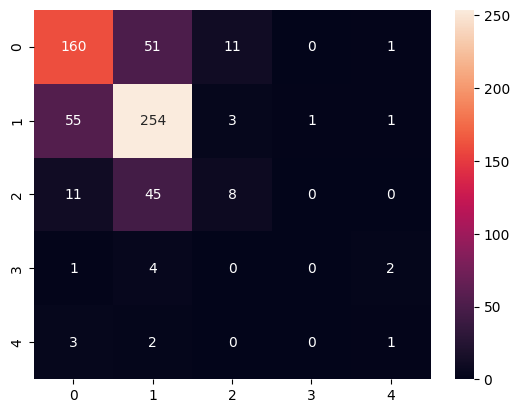

In [26]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g') # font size

In [27]:
# df_features_test = df_features.loc[y_test.index.tolist(), :]

# df_anl = pd.DataFrame({
#     "y_test": y_test.tolist(),
#     "y_pred": y_pred.tolist(),
#     "corpus_name": df_features.loc[y_test.index.tolist(), :]['corpus_name'].tolist(),  
# })

# for cp_nm in df_anl.corpus_name.unique():
    
#     print(f"""###############################################
# # corpus name: {cp_nm}
# ###############################################
#           """)
    
#     df_anl_cp = df_anl[df_anl.corpus_name == cp_nm]
    
#     print(classification_report(df_anl_cp.y_test, df_anl_cp.y_pred))
    
#     cm=confusion_matrix(df_anl_cp.y_test, df_anl_cp.y_pred)
#     sns.heatmap(cm, annot=True, fmt='g') # font size
#     plt.show()
    
# y_test_s = y_test.copy()
# y_test_s['corpus']

### Featue importance

In [28]:
# # Acessar o objeto RFE na pipeline
# rfe = pipeline.named_steps['selecting']
# # Acessar o array que indica quais características foram selecionadas
# selected_features_mask = rfe.support_

selected_features_mask = model.named_steps['selecting'].get_support()

# Usar o array para filtrar os nomes das colunas do DataFrame original
selected_features = X_train.columns[selected_features_mask].tolist()

print("Características selecionadas pelo RFE:")
print(selected_features)


Características selecionadas pelo RFE:
['parent_abafar', 'parent_abalar', 'parent_abandonar', 'parent_abastecer', 'parent_abismo', 'parent_abolir', 'parent_abordar', 'parent_abranger', 'parent_abraçar', 'parent_abrigar', 'parent_abrir', 'parent_abstrair', 'parent_acabar', 'parent_academia', 'parent_acalmar', 'parent_acariciar', 'parent_acatar', 'parent_aceitar', 'parent_acelerar', 'parent_acenar', 'parent_acender', 'parent_acertar', 'parent_acessar', 'parent_achar', 'parent_acionar', 'parent_aclamar', 'parent_acolher', 'parent_acompanhar', 'parent_aconselhar', 'parent_acontecer', 'parent_acordar', 'parent_acostumar', 'parent_acreditar', 'parent_acrescentar', 'parent_acumular', 'parent_acusar', 'parent_adaptar', 'parent_adequar', 'parent_aderir', 'parent_adiantar', 'parent_adiar', 'parent_adivinhar', 'parent_administrar', 'parent_admirar', 'parent_admitir', 'parent_adolescente', 'parent_adorar', 'parent_adormecer', 'parent_adotar', 'parent_adquirir', 'parent_adulterar', 'parent_advertir

In [29]:
# Função para remover a parte após o último underscore
def remover_apos_ultimo_underscore(s):
    return "_".join(s.split("_")[:-1])

original_features = [remover_apos_ultimo_underscore(feat) for feat in selected_features]

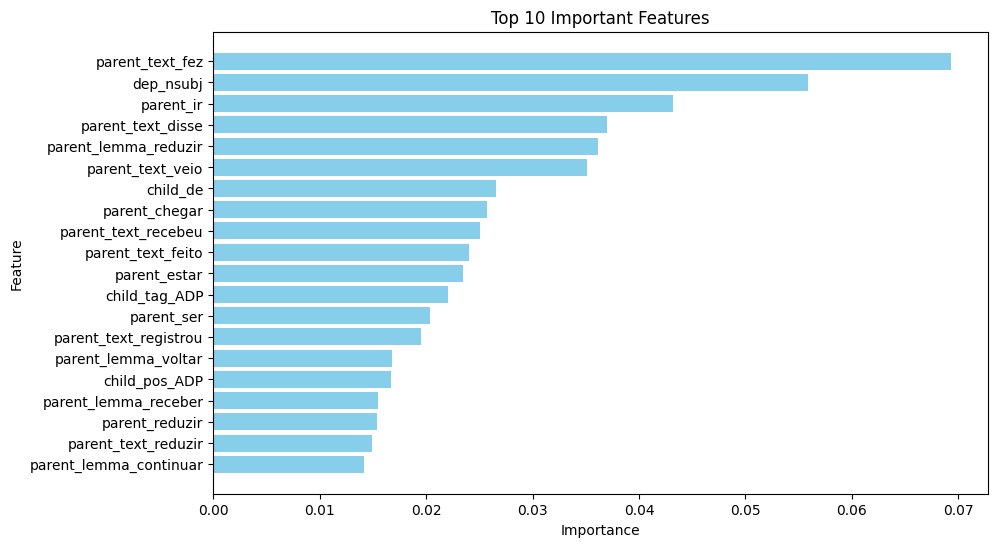

In [30]:
# Extrair o modelo XGBClassifier da pipeline
xgb_model = model.named_steps['estimator']

# Obter as importâncias das características
feature_importances = xgb_model.feature_importances_

# Criar um DataFrame para facilitar a manipulação e visualização
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    "original_feature": original_features,
    'importance': feature_importances
})

# Ordenar o DataFrame pelo valor de importância
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

# Plotar o gráfico de barras das principais características
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar a característica mais importante no topo
plt.show()


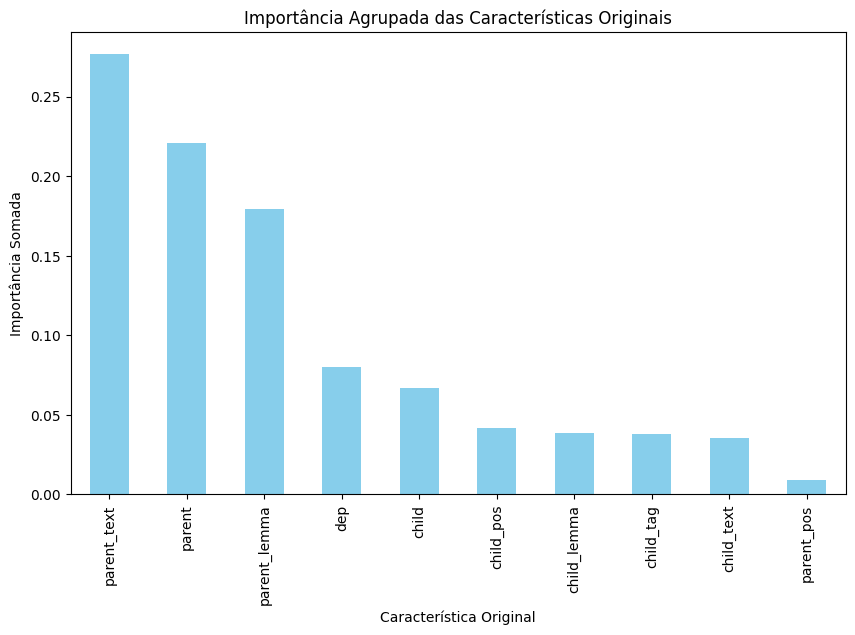

In [31]:
grouped_importances = feature_importance_df.groupby('original_feature')['importance'].sum().sort_values(ascending=False)
# Plotar o gráfico das características originais mais importantes
plt.figure(figsize=(10, 6))
grouped_importances.head(10).plot(kind='bar', color='skyblue')
plt.title('Importância Agrupada das Características Originais')
plt.xlabel('Característica Original')
plt.ylabel('Importância Somada')
plt.show()

### SHAP

In [32]:
# 1. Carregar o modelo treinado do pipeline
xgb_model = model.named_steps['estimator']

# 2. Criar o objeto Explainer para o modelo XGB
explainer = shap.TreeExplainer(xgb_model)

In [33]:

X_test_processed = X_test
for step in [step[0] for step in model.steps if step[0] != "estimator"]:
    
    print(step)
    
    if step == "sampling":
        pass
    else:
        X_test_processed = model[step].transform(X_test_processed)

scaling
sampling
selecting


In [34]:
# 3. Calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(X_test_processed)

In [35]:
df_X_test_anl = pd.DataFrame(X_test_processed, columns = selected_features)

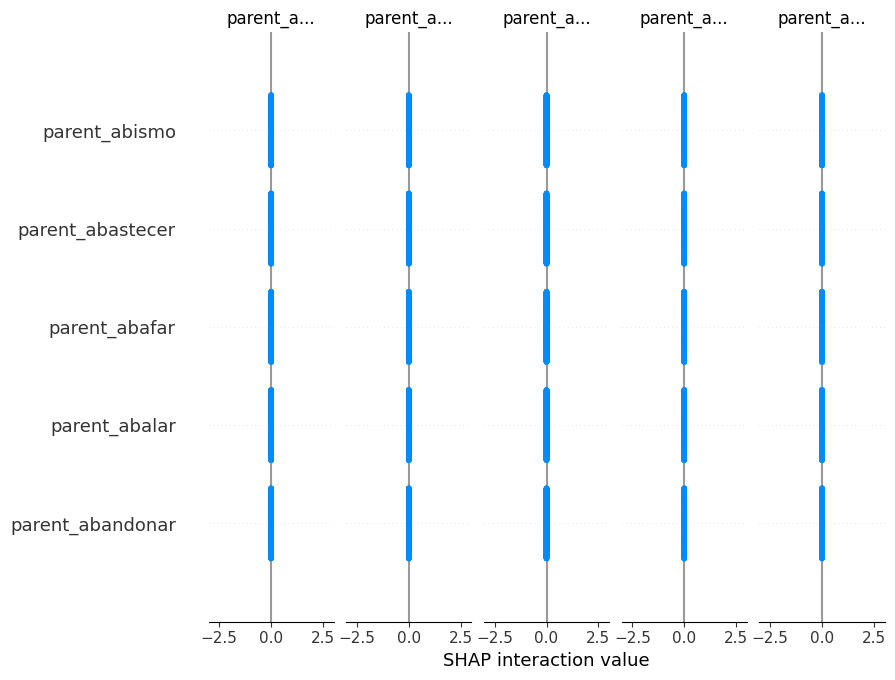

In [36]:
shap.summary_plot(shap_values, df_X_test_anl)
plt.show()

In [37]:
sh = explainer(X_test_processed)
sh.feature_names = selected_features

In [38]:
# ver quais features importaram em uma classificacao
shap.plots.waterfall(sh[0])

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (15072, 5)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [ ]:
# By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.
shap.plots.bar(sh)

In [ ]:
shap.plots.bar(sh.max(0))

In [ ]:
# Dependence Plot para cada feature
for feature in [col for col in df_X_test_anl.columns if "dep_" in col]:
    shap.dependence_plot(feature, shap_values, df_X_test_anl)
    plt.show()